Epoch 1/20, Train Loss: 0.12492635417341565, Val Loss: 0.037668628695731364
Epoch 2/20, Train Loss: 0.037055224898116045, Val Loss: 0.0349520870950073
Epoch 3/20, Train Loss: 0.034729062560169645, Val Loss: 0.03358719622095426
Epoch 4/20, Train Loss: 0.03304061650608977, Val Loss: 0.03290719189681113
Epoch 5/20, Train Loss: 0.032021879082700856, Val Loss: 0.031106109265238047
Epoch 6/20, Train Loss: 0.030609681406834472, Val Loss: 0.030253511232634384
Epoch 7/20, Train Loss: 0.029777566553093493, Val Loss: 0.029210101735467713
Epoch 8/20, Train Loss: 0.02898961033982535, Val Loss: 0.029301417293027043
Epoch 9/20, Train Loss: 0.028415128685689222, Val Loss: 0.02781889952408771
Epoch 10/20, Train Loss: 0.02714970240291829, Val Loss: 0.027744461316615343
Epoch 11/20, Train Loss: 0.02643799987466385, Val Loss: 0.027710988108689587
Epoch 12/20, Train Loss: 0.025748198134048533, Val Loss: 0.027932921502118308
Epoch 13/20, Train Loss: 0.02455715350030611, Val Loss: 0.02454492806767424
Epoch 1

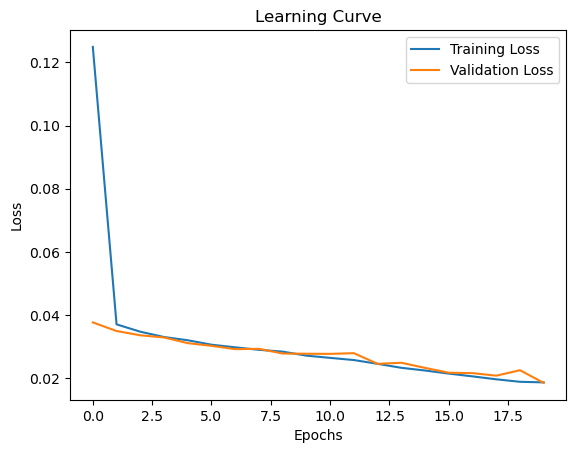

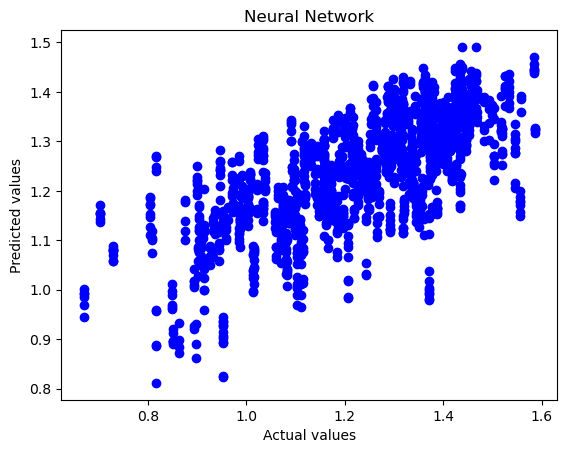

In [2]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset, random_split
import matplotlib.pyplot as plt

# Importing the dataset from Excel
filepath = '../DataGeneration/generate_data.xlsx'
dataset = pd.read_excel(filepath)

# Assuming the target variable is in the last column
X = dataset.iloc[:, 1:8].values
y = dataset.iloc[:, -1].values

# Apply one-hot encoding to specific columns (if needed)
# In this example, assuming one-hot encoding for the third column (index 2)
column_transformer = ColumnTransformer(
    transformers=[
        ('encoder', OneHotEncoder(), [3])  # Assuming one-hot encoding for the third column (index 2)
    ],
    remainder='passthrough'
)

X = column_transformer.fit_transform(X)

# Splitting the dataset into the Training set and Test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

# Feature Scaling (not necessary for neural networks, but can be applied)
sc_X = StandardScaler()
X_train = sc_X.fit_transform(X_train)
X_test = sc_X.transform(X_test)

# Convert data to PyTorch tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32).view(-1, 1)

X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32).view(-1, 1)

# Create a PyTorch dataset and DataLoader
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

batch_size = 64
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size)

# Define the neural network model
class NeuralNetwork(nn.Module):
    def __init__(self, input_size):
        super(NeuralNetwork, self).__init__()
        self.fc1 = nn.Linear(input_size, 128)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, 1)

    def forward(self, x):
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        x = self.relu(x)
        x = self.fc3(x)
        return x

# Instantiate the model and define the loss function and optimizer
input_size = X_train.shape[1]
model = NeuralNetwork(input_size)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Train the model
num_epochs = 20

train_losses = []
val_losses = []

for epoch in range(num_epochs):
    model.train()
    total_loss = 0.0
    for inputs, labels in train_loader:
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    # Validation loss
    model.eval()
    with torch.no_grad():
        val_loss = 0.0
        for inputs, labels in test_loader:
            outputs = model(inputs)
            val_loss += criterion(outputs, labels).item()

    avg_train_loss = total_loss / len(train_loader)
    avg_val_loss = val_loss / len(test_loader)

    train_losses.append(avg_train_loss)
    val_losses.append(avg_val_loss)

    print(f'Epoch {epoch + 1}/{num_epochs}, Train Loss: {avg_train_loss}, Val Loss: {avg_val_loss}')

# Evaluate the model on the test set
model.eval()
with torch.no_grad():
    y_pred_tensor = model(X_test_tensor)
    test_loss = criterion(y_pred_tensor, y_test_tensor)

# Convert predictions back to NumPy arrays
y_pred = y_pred_tensor.numpy()
y_test_np = y_test_tensor.numpy()

# Evaluate the Model Performance
mse = mean_squared_error(y_test_np, y_pred)
r2 = r2_score(y_test_np, y_pred)

print(f'Mean Squared Error: {mse}')
print(f'R-squared: {r2}')

# Plotting the learning curve
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.legend()
plt.title('Learning Curve')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.show()

# Plotting the results (optional)
plt.scatter(y_test, y_pred, color='blue')
plt.title('Neural Network')
plt.xlabel('Actual values')
plt.ylabel('Predicted values')
plt.show()
